# Cleaned Parsing Functions

In [131]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import re
import dateutil.parser
import datetime
import json
from ast import literal_eval


## Overview

Our goal is to extract relevant information on every article tagged with the `Codingbootcamp` tag.  
We accomplish this in three steps:
1. Iterate through each page of the archive for this tag.
2. On each date page (such as 2018/01/02), extract the urls for all links that correspond to articles published on that date tagged with `Codingbootcamp` (don't extract "Home", "signup" links etc).
3. On each url, call the single article parsing function to extract author, author_bio, title, publish date, publisher, and article text.

## Get HTML Function
**Base Source**: https://realpython.com/python-web-scraping-practical-introduction/  
**Update10/1/18**: This code originated from this tutorial but was later adapted in order complete step 3 - to get all articles tagged with `Codingbootcamp`. 
I added a second get html function that checked whether the web browser redirected you at some point when attempting to access the html at the provided link. This was necessary because when you attempted to access a page of the archive that didn't exist - such as attempting to access `archive/2013/03/02`, you are instead redirected back to the year or month page. In those situations, I didn't want to re-parse the articles on the main page, which would have been redundant parsing (and extra time in an already long function, and instead didn't parse a page that had been redirected.  
I had to keep this in a seperate function, because for certain single article urls, like "https://medium.freecodecamp.org/5-key-learnings-from-the-post-bootcamp-job-search-9a07468d2331" were redirected in the retreival process (I am not sure why). I attempted to come up with a elegant solution using response object attributes that would differentiate between article redirects and archive redirects, but was unable to do so. 
So the function that retrieves the html for articles doesn't check for redirects, but the function that retrieves archive page html does check for redirects. 

In [6]:
# Define get function to get raw HTML
def simple_get_article(url):
    """
    Attempts to get the content at `url` by making an HTTP GET request.
    If the content-type of response is some kind of HTML/XML, return the
    text content, otherwise return None.
    """
    try:
        #closing ensures any network resources are freed when out of scope - good practice
        with closing(get(url, stream=True)) as resp: 
            if is_good_response(resp):
                return resp.content
            else:
                return None

    except RequestException as e:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None

# Define get function to get raw HTML from the archive pages, with a twist.
def simple_get_archive(url):
    """
    Retrieves the raw html of a page in the `Codingbootcamp` tag archive (https://medium.com/tag/codingbootcamp/archive).
    But some pages of the archive don't exist (like 2013/01/02) because no stories were published on that date. 
    If you attempt to access these nonexistent urls, you are redirected to the main year or month page.
    We don't want to re-parse those pages (redundant code), so our hack-y solution is to check to see if the HTML response
    object has a redirect (302 status code) in its history. 
    This is defined as a separate function, because some of the article urls are redirected (I am not sure why), and I couldn't 
    come up with a clean solution that separates article redirection vs archive redirection. 
    """
    try:
        #closing ensures any network resources are freed when out of scope - good practice
        with closing(get(url, stream=True)) as resp: 
            if is_redirect(resp):
                return "redirect"
            elif is_good_response(resp):
                return resp.content
            else:
                return None

    except RequestException as e:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None
    
# I added this helper function to check if the HTML response returned by the browser had been redirected at some point
# See http://docs.python-requests.org/en/v0.10.6/api/ for docs on history attribute
def is_redirect(resp):
    """
    Returns True if the resp had been redirected at some point in the retrieval process due to nonexistent url, 
    False otherwise. 
    Arguments: a HTML response object
    """
    resp_history = resp.history
    if resp_history: #not empty - some things happend before response was returned
        # I specifically want to check for redirects (status code 302)
        statuses = [h.status_code==302 for h in resp_history]
        # Are there any true in the above list comp? Then something was redirected. 
        return np.any(statuses)
    else:
        return False
    
def is_good_response(resp):
    """
    Returns True if the response seems to be HTML, False otherwise.
    """
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1)


def log_error(e):
    """
    It is always a good idea to log errors. 
    This function just prints them, but you can
    make it do anything.
    """
    print(e)

## Single Article Info Parsing

The following functions return information parsed from a single article on Medium. 

In [7]:
def get_author(parsed_html):
    """Parses the author name from a Medium article. 
    Arguments:
        parsed_html: object returned by calling `BeautifulSoup(raw_html, 'html.parser')`
    Returns: 
        the author name as a string or None if author tag not present
    """
    author = parsed_html.find('meta', property="author")
    return author['content'] if author else None

def get_author_bio(parsed_html):
    """Parses the author's bio/description from a Medium article. 
    Arguments:
        parsed_html: object returned by calling `BeautifulSoup(raw_html, 'html.parser')`
    Returns: 
        the author bio/description as a string if it exists, and None otherwise
    """
    bios = parsed_html.find_all('div', class_="ui-caption ui-xs-clamp2 postMetaInline")
    # If bios is empty, that means there is no author bio for article, and the [0]  will error so we need to explicityly
    # check and return None if no author bio
    return bios[0].text if bios else None

def get_title(parsed_html):
    """Parses the title of a Medium article.
    Arguments:
        parsed_html: object returned by calling `BeautifulSoup(raw_html, 'html.parser')`
    Returns: 
        the title of the article as a string or None if title tag not present
    """
    title = parsed_html.find('meta', property='og:title')
    return title['content'] if title else None

def get_raw_publish_date(parsed_html):
    """Parses the date a Medium article was published. 
    Arguments:
        parsed_html: object returned by calling `BeautifulSoup(raw_html, 'html.parser')`
    Returns: 
        a raw/uncleaned publish date, which looks like '2016-11-19T16:48:30.365Z', or None if tag not present
    """
    date = parsed_html.find('meta', property='article:published_time')
    return date['content'] if date else None

def get_article_publisher(parsed_html):
    """Parses the article's publisher from a Medium article. 
    Arguments:
        parsed_html: object returned by calling `BeautifulSoup(raw_html, 'html.parser')`
    Notes:
        The publisher is encoded as "https://facebook.com/publisher" so I extract just the publisher name.
        Not all articles have a verified publisher - like if it's just the author's personal blog - so publisher is
        just "medium" in that case
    Returns:
        If article is hosted on verified publisher, returns publisher name as string
        If article is on personal blog, returns "medium" as a string. 
        If publisher tag doesn't exist, returns None
        
    """
    long_publisher = parsed_html.find("meta", property='article:publisher')
    return long_publisher['content'].split("/")[3] if long_publisher else None

def get_raw_article_text(parsed_html):
    """Extracts out the text/content of the Medium article.
    Arguments:
        parsed_html: object returned by calling `BeautifulSoup(raw_html, 'html.parser')`
    Returns:
        a raw/uncleaned string of text or None if tag is not present.
        The string is considered "raw" because there are some weird characters that are remants
        of header formatting and the like.
    """
    text = parsed_html.find_all('div', class_='postArticle-content')
    return text[0].text if text else None

def clean_text(text):
    """takes a string of text
    removes \xa0 and \u200a that are randomly splattered throughout text
    adds spaces after punctuation that appeared to be missing
    splits all words where a capital letter is in the middle of a word and puts a space in front of it and removes double spaces
    """
    if text:
        cleaned_text = text.replace("\xa0", " ").replace("\u200a", " ")
        cleaned_text = re.sub(r'(?<=[.,])(?=[^\s])', r' ', cleaned_text)
        cleaned_text = re.sub(r'([A-Z])', r' \1', cleaned_text).lstrip().replace("  ", " ")
        return cleaned_text
    else:
        # text is a None object which you can't use regex on.
        return text

def clean_date(date):
    """takes a string in RFC 339 format ('Y-M-D"T"H:M:S.MS"Z"')
    returns a string of format ('Y-M-D H:M:S')
    """
    if date:
        date = dateutil.parser.parse(date)
        date = date.strftime("%Y-%m-%d %H:%M:%S")
        return date
    else:
        # Date is a None object and you can't parse it
        return date
    
def get_tags(parsed_html):
    script_html = parsed_html.find("script", type='application/ld+json')
    script_data = json.loads(script_html.text)
    keywords_list = script_data['keywords']
    tags = []
    for elem in keywords_list:
        if elem.startswith("Tag:"):
            tags.append(elem[4:])
    return tags

def get_url(parsed_html):
    url = parsed_html.find("meta", property="al:web:url")
    return url["content"]


def get_all_article_info(article_url):
    """Parses a Medium article to get all needed information about author and story.
    Arguments:
        article_url: String of url for article to parse
    Returns:
        list of [author, author_bio, title, date, publisher article_text], where each component is a string or None
    """
    raw_html = simple_get_article(article_url)
    parsed_html = BeautifulSoup(raw_html, 'html.parser')
    author = get_author(parsed_html)
    author_bio = get_author_bio(parsed_html)
    title = get_title(parsed_html)
    raw_date = get_raw_publish_date(parsed_html)
    cleaned_date = clean_date(raw_date)
    publisher = get_article_publisher(parsed_html)
    raw_text = get_raw_article_text(parsed_html)
    cleaned_text = clean_text(raw_text)
    tags = get_tags(parsed_html)
    url = get_url(parsed_html)
    return [author, author_bio, title, cleaned_date, publisher, cleaned_text, tags, url]

In [8]:
## working on getting the tags of the article
# article_url = "https://medium.com/launch-school/were-not-a-bootcamp-c33901412c38"
# raw_html = simple_get_article(article_url)
# parsed_html = BeautifulSoup(raw_html, 'html.parser')
# # print(parsed_html)
# script_html = parsed_html.find("script", type='application/ld+json')
# long_publisher = parsed_html.find("meta", property='article:publisher')['content']
# # print(long_publisher)
# ## extract content of script https://stackoverflow.com/questions/26192727/extract-content-of-script-with-beautifulsoup
# script_data = json.loads(script_html.text)
# keywords_list = script_data['keywords']
# tags = []
# for elem in keywords_list:
#     if elem.startswith("Tag:"):
#         tags.append(elem[4:])
# # print(tags)

# def get_tags(parsed_html):
#     script_html = parsed_html.find("script", type='application/ld+json')
#     script_data = json.loads(script_html.text)
#     keywords_list = script_data['keywords']
#     tags = []
#     for elem in keywords_list:
#         if elem.startswith("Tag:"):
#             tags.append(elem[4:])
#     return tags

# get_tags(parsed_html)

In [9]:
## working on getting the url
# article_url = "https://medium.com/launch-school/were-not-a-bootcamp-c33901412c38"
# raw_html = simple_get_article(article_url)
# parsed_html = BeautifulSoup(raw_html, 'html.parser')
# def get_url(parsed_html):
#     url = parsed_html.find("meta", property="al:web:url")
#     return url["content"]
# get_url(parsed_html)


### Single Article Example Usage

In [10]:
test_url_1 = "https://medium.com/launch-school/were-not-a-bootcamp-c33901412c38"
get_all_article_info(test_url_1)

['Chris Lee',
 None,
 "We're Not a Bootcamp – Launch School – Medium",
 '2018-08-01 01:48:19',
 'medium',
 'We’re Not a Bootcamp We’re Something Unique, and Uniquely Effective Photo by Kyle Johnson on Unsplash One of the things about operating in a crowded marketplace is that you tend to get lumped in with the biggest names and most common stereotypes. In the programming education space, that means the now familiar label of “bootcamp. ” I often see people refer to Launch School as a “coding bootcamp, ” which may seem like a reasonable shortcut for helping people understand what we do; however, it fails to capture what makes us special. When I talk about Launch School and what we are trying to achieve, I don’t use the word “bootcamp. ” We are an online school for developers, but more than that, we are a school with an opinionated pedagogy that focuses on fundamentals first with the goal of building skills that last a career. So, why do I steer clear of the “bootcamp” label? To put it si

### Get all open post links from a page

In [11]:
def get_all_open_post_links(parsed_html):
    """Retrieves all links on a page that open to an article (does not return "home", "sign up" links etc).
    Arguments:
        parsed_html: object returned by calling `BeautifulSoup(raw_html, 'html.parser')`
    Notes:
        All links on a page that have the data-attribute 'open-post' are the types of links we want.
        find_all returns a special BeautifulSoup object so I need to extract the string url.
        I think there are muliple links for each post (like the title and "read more"), so returning array 
        has duplicates
    Returns:
        List of link strings
    """
    def href_open_post_data_action(tag):
        """Helper parsing function that checks to see if an "a" tag is an href with an 'open-post' data action.
        Arguments:
            tag: All html tags like <a>, <div> that BeautifulSoup has extracted
        Returns:
            true if tag has href and 'open-post' data-action attribute, false otherwise
        """
        return tag.has_attr('href') and tag.get('data-action') == 'open-post'
    
    link_objects =  parsed_html.find_all(href_open_post_data_action)
    return [link.get('href') for link in link_objects] #retrieves the string url from link object

The above function is the "middle level" function in the grand scheme of our parsing.  
First, we defined the function that parses information for a single article.  
The next step is to retrieve all the links to articles on a web page (like the web page returned by searching "coding bootcamp" for example), and then call our single article parsing function on each link we extracted from the page.  
Note - the name is "open post" links because there are a ton of links on a webpage - to "home", to "sign-up", to "search" etc. We are only interested in extracting the links that correspond to articles about coding bootcamps.  
After inspecting the source html, I discovered that all links that open to coding bootcamp articles have the attribute "data-action" set to "open-post" within the html `<a href>` tag. So this function ensures that it only extracts the links we want. 

## Iterate Through All Dates in Archive

The next step is to define a function that will iterate through each "date" page in the archive, gather all the open post links for each "date" page (i.e. all the story links), and then call the single article parser on each link.  
**NOTE**: The following function is currently defined such that it will *ONLY* work on the archive for the `Codingbootcamp` (https://medium.com/tag/codingbootcamp/archive) because currently it operates on the assumption that the years 2013 and 2014 have so few articles that they are not seperated by month or day, only year. 

In [12]:
def format_dates_for_url(integer_date):
    """
    Formats dates to enter into the archive url, which requires numbers < 10 to be encoded with a "0" in front,
    but Python doesn't allow 01 as an integer. 
    """
    if integer_date < 10:
        return str(0) + str(integer_date)
    else:
        return str(integer_date)
def get_specific_Codingbootcamp_links():
    # For current range of years available
    years = range(2013, 2019)
    months_w_o_zero_in_front = range(1, 13)
    days_w_o_zero = range(1, 32)
    base_url = "https://medium.com/tag/codingbootcamp/archive"
    # Collector variable to story all story urls
    story_links = []
    for year in years:
        # These years don't have month, day subdivisions so to prevent redundant parsing, 
        # just parse the base year and its links.
        if year == 2013 or year == 2014:
            # 
            url = base_url + "/" + format_dates_for_url(year)
            raw_year_html = simple_get_archive(url)
            # If raw_year_html is None, can't parse it so skip
            if not raw_year_html:
                break
            parsed_year_html = BeautifulSoup(raw_year_html, 'html.parser')
            links = get_all_open_post_links(parsed_year_html)
            #use extend instead of append because just want to add elements, not create nested lists.
            story_links.extend(links) 
        else:
            for month in months_w_o_zero_in_front:
                for day in days_w_o_zero:
                    url = base_url + "/" + format_dates_for_url(year) + format_dates_for_url(month) + "/" + format_dates_for_url(day)
                    raw_day_html = simple_get_archive(url)
                    # 2015, 2016, 2017, 2018 have some dates with no stories, so GET requests are redirected
                    # and we don't want to parse stuff we already did.
                    if raw_day_html == "redirect":
                        #skip the redirected day - advance in for loop
                        break
                    # If raw_day_html is None, can't parse it so skip
                    elif not raw_day_html:
                        break
                    parsed_day_html = BeautifulSoup(raw_day_html, 'html.parser')
                    links = get_all_open_post_links(parsed_day_html)
                    #use extend instead of append because just want to add elements, not create nested lists.
                    story_links.extend(links)
    # Create a set of links to remove duplicates and then turn back into a list (better data structure)
    return list(set(story_links))

### Collect Text Data

In [13]:
# List of urls for all stories tagged with `Codingbootcamp`
story_links = get_specific_Codingbootcamp_links()

In [ ]:
# Get all info like article, publisher, etc for each url gathered above
# THIS CELL TAKES FOREVER BE WARNED - DO NOT CLOSE COMPUTER WHILE RUNNING ELSE THE CONNECTION BREAKS
story_info_list = []
for url in story_links:
    story_info_list.append(get_all_article_info(url))

In [ ]:
column_names = ["author", "author_bio", "title", "date", "publisher", "text", "tags", "url"]
Codingbootcamp_info = pd.DataFrame(story_info_list, columns = column_names)

In [ ]:
Codingbootcamp_info

In [ ]:
#Convert to csv so I don't have to run the collection function again - it takes FOREVER
Codingbootcamp_info.to_csv("codingbootcamp_articles_info.csv", index=False)

In [50]:
Codingbootcamp_info = pd.read_csv("codingbootcamp_articles_info.txt")

#make sure that the tag column is not a string but a list
Codingbootcamp_info["tags"] = Codingbootcamp_info["tags"].apply(literal_eval)
Codingbootcamp_info


,author,author_bio,title,date,publisher,text,tags,url,score
0,Gregorio Rojas,Founder @WeSabio - #LearnToCode - I Blog @ htt...,LinkedIn Outcomes Report of Coding Bootcamps –...,2016-06-01 22:46:01,wesabio,Linked In Outcomes Report of Coding Bootcamps ...,"[Learning To Code, Coding Bootcamps]",https://researchcodingbootcamps.com/linkedin-o...,10
1,Emily Deans,"Washington, D.C.-based web developer. Former c...",Middleware/End of Week – Emily Deans – Medium,2017-07-28 20:01:22,medium,Middleware/ End of Week The last few days we’v...,"[JavaScript, Lesbians Who Tech, Women Who Code...",https://medium.com/@emilyldeans/middleware-end...,0
2,Verity Honebon,NaN,Week 6 — working in groups (Airbnb clone) – Ve...,2017-07-31 10:57:36,medium,Week 6 — working in groups ( Airbnb clone) The...,"[Agile, Codingbootcamp, Coding, Teamwork, Java...",https://medium.com/@verityhonebon/week-6-worki...,1
3,Emily Chai,"A student at Maker’s, aspiring full stack deve...",Hunting for a first job as a developer – Emily...,2017-05-13 10:44:31,medium,Hunting for a first job as a developer Passing...,"[Job Hunting, Developer, Makersacademy, Coding...",https://medium.com/@emilyxchai/hunting-for-a-f...,0
4,Jackson McGehee,Web Dev | Software Engineer | Creative Strateg...,Notes from U̶n̶d̶e̶r̶g̶r̶o̶u̶n̶d̶ Week Nine – ...,2018-02-02 17:30:29,medium,Notes from U̶n̶d̶e̶r̶g̶r̶o̶u̶n̶d̶ Week Nine I ...,"[Web Development, JavaScript, Codingbootcamp]",https://medium.com/@jacksonfullstack/notes-fro...,0
5,Bree Jackson,NaN,This is a homework assignment you see. – Bree ...,2017-08-11 03:11:39,medium,This is a homework assignment you see. As a po...,"[Life, Codingbootcamp, Friends, Journey, Learn...",https://medium.com/@breejax/as-a-possible-futu...,0
6,Sara Jo Helba,"I love riding and training horses, hiking, coo...",Starting at Fullstack Academy – Sara Jo Helba ...,2017-07-21 19:13:17,medium,Starting at Fullstack Academy My Path to Codin...,"[Programming, Learning To Code, Codingbootcamp]",https://medium.com/@sjhelba/starting-at-fullst...,3
7,Emmanuel Amon,Excited @TheIronYard Student,The Beginning — Journey to becoming a junior d...,2017-07-15 18:23:18,medium,The Beginning — Journey to becoming a junior d...,"[Web Development, First Post, Codingbootcamp, ...",https://medium.com/@emmanuelamon92/the-beginni...,4
8,sam foong,NaN,Coding akin to drinking from a firehose? – sam...,2018-03-07 02:08:16,medium,Coding akin to drinking from a firehose? Over ...,"[Web Development, Codingbootcamp]",https://medium.com/@samfoong88/coding-akin-to-...,0
9,Joseph Cardillo,"Curious about everything. Literature, Fiction,...",Coding Bootcamp: Week 1 – Joseph Cardillo – Me...,2018-03-01 11:17:01,medium,They encouraged us to start a journal or blog ...,"[Web Development, Codingbootcamp]",https://medium.com/@josephcardillo/they-encour...,0


In [51]:
#see frequency of different tags
Codingbootcamp_info["tags"].value_counts()

TypeError: unhashable type: 'list'

We cannot get the value_counts of a list object so we need to get a little creative in order to get the value_counts of the elements in the list (tag column).

In [52]:
newdf = Codingbootcamp_info["tags"].apply(pd.Series).stack().reset_index(level=1, drop=True).to_frame('tags')
newdf["tags"].value_counts()

Codingbootcamp             967
Coding                     467
Programming                407
Web Development            205
JavaScript                 176
Learning To Code            99
Education                   86
Women In Tech               71
Software Development        59
Tech                        49
Ruby                        48
Technology                  46
The Iron Yard               41
Coding Bootcamps            41
Internships                 34
Ruby on Rails               33
Career Change               33
Startup                     32
Bootcamp                    32
Learn To Code               30
Freecodecamp                30
Code Newbie                 28
Ecole 42                    28
Coding Bootcamp             28
Code                        26
React                       26
Chingu                      24
Life Lessons                24
Women Who Code              22
Computer Science            21
                          ... 
Netherlands                  1
GraphQL 

I will play around with this more later, but for now let's look at gender of the names! We need more data than just the author name, in order to tell if they are male or female, so I am going to import the babynames data from the SSN website which may have information that is useful.

In [5]:
import urllib.request
import os.path
w
data_url = "https://www.ssa.gov/oact/babynames/names.zip"
local_filename = "babynames.zip"
if not os.path.exists(local_filename): # if the data exists don't download again
    with urllib.request.urlopen(data_url) as resp, open(local_filename, 'wb') as f:
        f.write(resp.read())

The data is organized into separate files in the format `yobYYYY.txt` with each file containing the `name`, `sex`, and `count` of babies registered in that year. Now we load the data directly into Python without unzipping in order to increase efficiency.

In [6]:
import zipfile
babynames = [] 
with zipfile.ZipFile(local_filename, "r") as zf:
    data_files = [f for f in zf.filelist if f.filename[-3:] == "txt"]
    def extract_year_from_filename(fn):
        return int(fn[3:7])
    for f in data_files:
        year = extract_year_from_filename(f.filename)
        with zf.open(f) as fp:
            df = pd.read_csv(fp, names=["Name", "Sex", "Count"])
            df["Year"] = year
            babynames.append(df)
babynames = pd.concat(babynames)

In [7]:
babynames.head()

,Name,Sex,Count,Year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


Yay now we have a babynames dataset to use!

Let's start off my making the names in the babynames dataset and our own data frame, lowercase (for standardization purposes so we can easily find patterns and matches). I'll create a new column for the lowercase name so we don't lose the original data.

In [8]:
babynames["LName"] = babynames["Name"].str.lower()
babynames.head()

,Name,Sex,Count,Year,LName
0,Mary,F,7065,1880,mary
1,Anna,F,2604,1880,anna
2,Emma,F,2003,1880,emma
3,Elizabeth,F,1939,1880,elizabeth
4,Minnie,F,1746,1880,minnie


In [9]:
Codingbootcamp_info["lowercase author"] = Codingbootcamp_info["author"].str.lower()
Codingbootcamp_info.head()

,author,author_bio,title,date,publisher,text,tags,url,score,lowercase author
0,Gregorio Rojas,Founder @WeSabio - #LearnToCode - I Blog @ htt...,LinkedIn Outcomes Report of Coding Bootcamps –...,2016-06-01 22:46:01,wesabio,Linked In Outcomes Report of Coding Bootcamps ...,"['Learning To Code', 'Coding Bootcamps']",https://researchcodingbootcamps.com/linkedin-o...,10,gregorio rojas
1,Emily Deans,"Washington, D.C.-based web developer. Former c...",Middleware/End of Week – Emily Deans – Medium,2017-07-28 20:01:22,medium,Middleware/ End of Week The last few days we’v...,"['JavaScript', 'Lesbians Who Tech', 'Women Who...",https://medium.com/@emilyldeans/middleware-end...,0,emily deans
2,Verity Honebon,NaN,Week 6 — working in groups (Airbnb clone) – Ve...,2017-07-31 10:57:36,medium,Week 6 — working in groups ( Airbnb clone) The...,"['Agile', 'Codingbootcamp', 'Coding', 'Teamwor...",https://medium.com/@verityhonebon/week-6-worki...,1,verity honebon
3,Emily Chai,"A student at Maker’s, aspiring full stack deve...",Hunting for a first job as a developer – Emily...,2017-05-13 10:44:31,medium,Hunting for a first job as a developer Passing...,"['Job Hunting', 'Developer', 'Makersacademy', ...",https://medium.com/@emilyxchai/hunting-for-a-f...,0,emily chai
4,Jackson McGehee,Web Dev | Software Engineer | Creative Strateg...,Notes from U̶n̶d̶e̶r̶g̶r̶o̶u̶n̶d̶ Week Nine – ...,2018-02-02 17:30:29,medium,Notes from U̶n̶d̶e̶r̶g̶r̶o̶u̶n̶d̶ Week Nine I ...,"['Web Development', 'JavaScript', 'Codingbootc...",https://medium.com/@jacksonfullstack/notes-fro...,0,jackson mcgehee


See the total number of babies with each name broken down by sex.

In [10]:
sex_counts = pd.pivot_table(babynames, index='LName', columns='Sex', values='Count',
                            aggfunc='sum', fill_value=0., margins=True)
sex_counts.head()

Sex,F,M,All
LName,,,
aaban,0.0,107.0,107.0
aabha,35.0,0.0,35.0
aabid,0.0,10.0,10.0
aabir,0.0,5.0,5.0
aabriella,32.0,0.0,32.0


Calculate the probability a name is female:

In [11]:
prob_female = sex_counts['F'] / sex_counts['All'] 
prob_female.head(10)

LName
aaban        0.000000
aabha        1.000000
aabid        0.000000
aabir        0.000000
aabriella    1.000000
aada         1.000000
aadam        0.000000
aadan        0.000000
aadarsh      0.000000
aaden        0.001073
dtype: float64

In [12]:
prob_female["shalini"]

1.0

Similarly, we can calculate the probability a name is male:

In [13]:
prob_male = sex_counts['M'] / sex_counts['All'] 
prob_male.head(10)

LName
aaban        1.000000
aabha        0.000000
aabid        1.000000
aabir        1.000000
aabriella    0.000000
aada         0.000000
aadam        1.000000
aadan        1.000000
aadarsh      1.000000
aaden        0.998927
dtype: float64

I will define a function to return the most likely `Sex` for a name. If there is an exact tie, the function returns Male. If the name does not appear in the social security dataset, return Unknown.

In [60]:
def sex_from_name(name):
    lower_name = name.lower()
    if lower_name in prob_female.index:
        return 'F' if prob_female[lower_name] > 0.5 else 'M'
    else:
        return "Unknown"

def prob_female_from_name(name):
    lower_name = name.lower()
    if lower_name in prob_female.index:
        return prob_female[lower_name] 
    else:
        return "Unknown"
    
def prob_male_from_name(name):
    lower_name = name.lower()
    if lower_name in prob_male.index:
        return prob_male[lower_name] 
    else:
        return "Unknown"

In [61]:
shalini_sex = sex_from_name('shalini')
shalini_sex

'F'

In [62]:
sex_from_name('aaden')

'M'

In [64]:
prob_female_from_name('shalini')

1.0

Now let me find a way to apply this function to our own dataframe in order to predict the gender of the different authors.
Next steps:
* Need to get the first name of the author
* Filter out any companies/orgs that may be in the author column
* Apply sex_from_name function to names in the bootcamp dataframe
* Have a confidence interval (if possible) or different measure of how sure we are about the given gender
* Create different dataframes with org data and personal data (as publisher/author)

Let's go back to our dataframe and filter out anything that may be companies or organizations

In [22]:
Codingbootcamp_info.head()

,author,author_bio,title,date,publisher,text,tags,url,score,lowercase author
0,Gregorio Rojas,Founder @WeSabio - #LearnToCode - I Blog @ htt...,LinkedIn Outcomes Report of Coding Bootcamps –...,2016-06-01 22:46:01,wesabio,Linked In Outcomes Report of Coding Bootcamps ...,"['Learning To Code', 'Coding Bootcamps']",https://researchcodingbootcamps.com/linkedin-o...,10,gregorio rojas
1,Emily Deans,"Washington, D.C.-based web developer. Former c...",Middleware/End of Week – Emily Deans – Medium,2017-07-28 20:01:22,medium,Middleware/ End of Week The last few days we’v...,"['JavaScript', 'Lesbians Who Tech', 'Women Who...",https://medium.com/@emilyldeans/middleware-end...,0,emily deans
2,Verity Honebon,NaN,Week 6 — working in groups (Airbnb clone) – Ve...,2017-07-31 10:57:36,medium,Week 6 — working in groups ( Airbnb clone) The...,"['Agile', 'Codingbootcamp', 'Coding', 'Teamwor...",https://medium.com/@verityhonebon/week-6-worki...,1,verity honebon
3,Emily Chai,"A student at Maker’s, aspiring full stack deve...",Hunting for a first job as a developer – Emily...,2017-05-13 10:44:31,medium,Hunting for a first job as a developer Passing...,"['Job Hunting', 'Developer', 'Makersacademy', ...",https://medium.com/@emilyxchai/hunting-for-a-f...,0,emily chai
4,Jackson McGehee,Web Dev | Software Engineer | Creative Strateg...,Notes from U̶n̶d̶e̶r̶g̶r̶o̶u̶n̶d̶ Week Nine – ...,2018-02-02 17:30:29,medium,Notes from U̶n̶d̶e̶r̶g̶r̶o̶u̶n̶d̶ Week Nine I ...,"['Web Development', 'JavaScript', 'Codingbootc...",https://medium.com/@jacksonfullstack/notes-fro...,0,jackson mcgehee


A list of the things to filter out: when publisher is wesabio, code.likeagirl.io, makersacademy, hackernoon, fuerzamuktek, codeburst, ubiqum, fundapps, itnext.io, propulsioncodingacademy, PrototyprIO.

In [23]:
orgs = ["wesabio", "code.likeagirl.io", "makersacademy", "hackernoon", "fuerzamuktek", "codeburst", "ubiqum", "fundapps", "itnext.io", "propulsioncodingacademy", "PrototyprIO"]
new_codingdf = Codingbootcamp_info[~Codingbootcamp_info["publisher"].isin(orgs)]
orgs_df = Codingbootcamp_info[Codingbootcamp_info["publisher"].isin(orgs)]
new_codingdf

,author,author_bio,title,date,publisher,text,tags,url,score,lowercase author
1,Emily Deans,"Washington, D.C.-based web developer. Former c...",Middleware/End of Week – Emily Deans – Medium,2017-07-28 20:01:22,medium,Middleware/ End of Week The last few days we’v...,"['JavaScript', 'Lesbians Who Tech', 'Women Who...",https://medium.com/@emilyldeans/middleware-end...,0,emily deans
2,Verity Honebon,NaN,Week 6 — working in groups (Airbnb clone) – Ve...,2017-07-31 10:57:36,medium,Week 6 — working in groups ( Airbnb clone) The...,"['Agile', 'Codingbootcamp', 'Coding', 'Teamwor...",https://medium.com/@verityhonebon/week-6-worki...,1,verity honebon
3,Emily Chai,"A student at Maker’s, aspiring full stack deve...",Hunting for a first job as a developer – Emily...,2017-05-13 10:44:31,medium,Hunting for a first job as a developer Passing...,"['Job Hunting', 'Developer', 'Makersacademy', ...",https://medium.com/@emilyxchai/hunting-for-a-f...,0,emily chai
4,Jackson McGehee,Web Dev | Software Engineer | Creative Strateg...,Notes from U̶n̶d̶e̶r̶g̶r̶o̶u̶n̶d̶ Week Nine – ...,2018-02-02 17:30:29,medium,Notes from U̶n̶d̶e̶r̶g̶r̶o̶u̶n̶d̶ Week Nine I ...,"['Web Development', 'JavaScript', 'Codingbootc...",https://medium.com/@jacksonfullstack/notes-fro...,0,jackson mcgehee
5,Bree Jackson,NaN,This is a homework assignment you see. – Bree ...,2017-08-11 03:11:39,medium,This is a homework assignment you see. As a po...,"['Life', 'Codingbootcamp', 'Friends', 'Journey...",https://medium.com/@breejax/as-a-possible-futu...,0,bree jackson
6,Sara Jo Helba,"I love riding and training horses, hiking, coo...",Starting at Fullstack Academy – Sara Jo Helba ...,2017-07-21 19:13:17,medium,Starting at Fullstack Academy My Path to Codin...,"['Programming', 'Learning To Code', 'Codingboo...",https://medium.com/@sjhelba/starting-at-fullst...,3,sara jo helba
7,Emmanuel Amon,Excited @TheIronYard Student,The Beginning — Journey to becoming a junior d...,2017-07-15 18:23:18,medium,The Beginning — Journey to becoming a junior d...,"['Web Development', 'First Post', 'Codingbootc...",https://medium.com/@emmanuelamon92/the-beginni...,4,emmanuel amon
8,sam foong,NaN,Coding akin to drinking from a firehose? – sam...,2018-03-07 02:08:16,medium,Coding akin to drinking from a firehose? Over ...,"['Web Development', 'Codingbootcamp']",https://medium.com/@samfoong88/coding-akin-to-...,0,sam foong
9,Joseph Cardillo,"Curious about everything. Literature, Fiction,...",Coding Bootcamp: Week 1 – Joseph Cardillo – Me...,2018-03-01 11:17:01,medium,They encouraged us to start a journal or blog ...,"['Web Development', 'Codingbootcamp']",https://medium.com/@josephcardillo/they-encour...,0,joseph cardillo
10,Joe Andy,Fullstack Web Developer interested in learning...,Good Coding Habits – Joe Andy – Medium,2018-05-25 08:21:34,medium,Good Coding Habits Photo by Markus Spiske on U...,"['Programming', 'Good Coding Practice', 'Codin...",https://medium.com/@josephiznot/good-coding-ha...,0,joe andy


From a manual look at the filtered dataframe, I am also going to filter out rows that have author KeepCoding, Better Developer, Manchester Codes, Code Collective, Accelerate Tech, Rithm School.

In [24]:
more_orgs = ["KeepCoding", "Better Developer", "Manchester Codes", "Code Collective", "Accelerate Tech", "Rithm School"]
new_codingdf = new_codingdf[~new_codingdf["author"].isin(more_orgs)]
new_codingdf

,author,author_bio,title,date,publisher,text,tags,url,score,lowercase author
1,Emily Deans,"Washington, D.C.-based web developer. Former c...",Middleware/End of Week – Emily Deans – Medium,2017-07-28 20:01:22,medium,Middleware/ End of Week The last few days we’v...,"['JavaScript', 'Lesbians Who Tech', 'Women Who...",https://medium.com/@emilyldeans/middleware-end...,0,emily deans
2,Verity Honebon,NaN,Week 6 — working in groups (Airbnb clone) – Ve...,2017-07-31 10:57:36,medium,Week 6 — working in groups ( Airbnb clone) The...,"['Agile', 'Codingbootcamp', 'Coding', 'Teamwor...",https://medium.com/@verityhonebon/week-6-worki...,1,verity honebon
3,Emily Chai,"A student at Maker’s, aspiring full stack deve...",Hunting for a first job as a developer – Emily...,2017-05-13 10:44:31,medium,Hunting for a first job as a developer Passing...,"['Job Hunting', 'Developer', 'Makersacademy', ...",https://medium.com/@emilyxchai/hunting-for-a-f...,0,emily chai
4,Jackson McGehee,Web Dev | Software Engineer | Creative Strateg...,Notes from U̶n̶d̶e̶r̶g̶r̶o̶u̶n̶d̶ Week Nine – ...,2018-02-02 17:30:29,medium,Notes from U̶n̶d̶e̶r̶g̶r̶o̶u̶n̶d̶ Week Nine I ...,"['Web Development', 'JavaScript', 'Codingbootc...",https://medium.com/@jacksonfullstack/notes-fro...,0,jackson mcgehee
5,Bree Jackson,NaN,This is a homework assignment you see. – Bree ...,2017-08-11 03:11:39,medium,This is a homework assignment you see. As a po...,"['Life', 'Codingbootcamp', 'Friends', 'Journey...",https://medium.com/@breejax/as-a-possible-futu...,0,bree jackson
6,Sara Jo Helba,"I love riding and training horses, hiking, coo...",Starting at Fullstack Academy – Sara Jo Helba ...,2017-07-21 19:13:17,medium,Starting at Fullstack Academy My Path to Codin...,"['Programming', 'Learning To Code', 'Codingboo...",https://medium.com/@sjhelba/starting-at-fullst...,3,sara jo helba
7,Emmanuel Amon,Excited @TheIronYard Student,The Beginning — Journey to becoming a junior d...,2017-07-15 18:23:18,medium,The Beginning — Journey to becoming a junior d...,"['Web Development', 'First Post', 'Codingbootc...",https://medium.com/@emmanuelamon92/the-beginni...,4,emmanuel amon
8,sam foong,NaN,Coding akin to drinking from a firehose? – sam...,2018-03-07 02:08:16,medium,Coding akin to drinking from a firehose? Over ...,"['Web Development', 'Codingbootcamp']",https://medium.com/@samfoong88/coding-akin-to-...,0,sam foong
9,Joseph Cardillo,"Curious about everything. Literature, Fiction,...",Coding Bootcamp: Week 1 – Joseph Cardillo – Me...,2018-03-01 11:17:01,medium,They encouraged us to start a journal or blog ...,"['Web Development', 'Codingbootcamp']",https://medium.com/@josephcardillo/they-encour...,0,joseph cardillo
10,Joe Andy,Fullstack Web Developer interested in learning...,Good Coding Habits – Joe Andy – Medium,2018-05-25 08:21:34,medium,Good Coding Habits Photo by Markus Spiske on U...,"['Programming', 'Good Coding Practice', 'Codin...",https://medium.com/@josephiznot/good-coding-ha...,0,joe andy


Now I need to get the first name of the author in "lowercase author" in order to put it through the gender function.

In [25]:
new_codingdf["first name"] = new_codingdf["lowercase author"].str.split(' ').str.get(0)
new_codingdf.head()

/Users/shalini/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,author,author_bio,title,date,publisher,text,tags,url,score,lowercase author,first name
1,Emily Deans,"Washington, D.C.-based web developer. Former c...",Middleware/End of Week – Emily Deans – Medium,2017-07-28 20:01:22,medium,Middleware/ End of Week The last few days we’v...,"['JavaScript', 'Lesbians Who Tech', 'Women Who...",https://medium.com/@emilyldeans/middleware-end...,0,emily deans,emily
2,Verity Honebon,NaN,Week 6 — working in groups (Airbnb clone) – Ve...,2017-07-31 10:57:36,medium,Week 6 — working in groups ( Airbnb clone) The...,"['Agile', 'Codingbootcamp', 'Coding', 'Teamwor...",https://medium.com/@verityhonebon/week-6-worki...,1,verity honebon,verity
3,Emily Chai,"A student at Maker’s, aspiring full stack deve...",Hunting for a first job as a developer – Emily...,2017-05-13 10:44:31,medium,Hunting for a first job as a developer Passing...,"['Job Hunting', 'Developer', 'Makersacademy', ...",https://medium.com/@emilyxchai/hunting-for-a-f...,0,emily chai,emily
4,Jackson McGehee,Web Dev | Software Engineer | Creative Strateg...,Notes from U̶n̶d̶e̶r̶g̶r̶o̶u̶n̶d̶ Week Nine – ...,2018-02-02 17:30:29,medium,Notes from U̶n̶d̶e̶r̶g̶r̶o̶u̶n̶d̶ Week Nine I ...,"['Web Development', 'JavaScript', 'Codingbootc...",https://medium.com/@jacksonfullstack/notes-fro...,0,jackson mcgehee,jackson
5,Bree Jackson,NaN,This is a homework assignment you see. – Bree ...,2017-08-11 03:11:39,medium,This is a homework assignment you see. As a po...,"['Life', 'Codingbootcamp', 'Friends', 'Journey...",https://medium.com/@breejax/as-a-possible-futu...,0,bree jackson,bree


Now put it through the gender function

In [65]:
new_codingdf["gender"] = new_codingdf["first name"].apply(sex_from_name)
new_codingdf["prob_female"] = new_codingdf["first name"].apply(prob_female_from_name)
new_codingdf["prob_male"] = new_codingdf["first name"].apply(prob_male_from_name)

/Users/shalini/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/shalini/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/shalini/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [66]:
new_codingdf.head()

,author,author_bio,title,date,publisher,text,tags,url,score,lowercase author,first name,gender,prob_female,prob_male
1,Emily Deans,"Washington, D.C.-based web developer. Former c...",Middleware/End of Week – Emily Deans – Medium,2017-07-28 20:01:22,medium,Middleware/ End of Week The last few days we’v...,"['JavaScript', 'Lesbians Who Tech', 'Women Who...",https://medium.com/@emilyldeans/middleware-end...,0,emily deans,emily,F,0.997932,0.00206823
2,Verity Honebon,NaN,Week 6 — working in groups (Airbnb clone) – Ve...,2017-07-31 10:57:36,medium,Week 6 — working in groups ( Airbnb clone) The...,"['Agile', 'Codingbootcamp', 'Coding', 'Teamwor...",https://medium.com/@verityhonebon/week-6-worki...,1,verity honebon,verity,F,1,0
3,Emily Chai,"A student at Maker’s, aspiring full stack deve...",Hunting for a first job as a developer – Emily...,2017-05-13 10:44:31,medium,Hunting for a first job as a developer Passing...,"['Job Hunting', 'Developer', 'Makersacademy', ...",https://medium.com/@emilyxchai/hunting-for-a-f...,0,emily chai,emily,F,0.997932,0.00206823
4,Jackson McGehee,Web Dev | Software Engineer | Creative Strateg...,Notes from U̶n̶d̶e̶r̶g̶r̶o̶u̶n̶d̶ Week Nine – ...,2018-02-02 17:30:29,medium,Notes from U̶n̶d̶e̶r̶g̶r̶o̶u̶n̶d̶ Week Nine I ...,"['Web Development', 'JavaScript', 'Codingbootc...",https://medium.com/@jacksonfullstack/notes-fro...,0,jackson mcgehee,jackson,M,0.00264886,0.997351
5,Bree Jackson,NaN,This is a homework assignment you see. – Bree ...,2017-08-11 03:11:39,medium,This is a homework assignment you see. As a po...,"['Life', 'Codingbootcamp', 'Friends', 'Journey...",https://medium.com/@breejax/as-a-possible-futu...,0,bree jackson,bree,F,0.997997,0.0020033


In [67]:
new_codingdf["gender"].value_counts()

M          493
F          224
Unknown    209
Name: gender, dtype: int64

We have quite a few unknowns in our dataset (almost one fourth, so let's just take a look at these values)

In [68]:
new_codingdf[new_codingdf["gender"] == "Unknown"]

,author,author_bio,title,date,publisher,text,tags,url,score,lowercase author,first name,gender,prob_female,prob_male
15,Zaynaib Giwa,Full Stack Developer | Aspiring Data Scientist...,Learning How to Learn – Zaynaib Giwa – Medium,2017-10-02 05:37:17,medium,Learning How to Learn I recently finished the ...,"['Productivity', 'Codingbootcamp', 'Codelikeag...",https://medium.com/@zaynaibg/learning-how-to-l...,0,zaynaib giwa,zaynaib,Unknown,Unknown,Unknown
22,it’s jennilyn,Proud to be a #WomanInTech. Software developer...,(Insert weird analogy here) for Git – it’s jen...,2017-06-02 01:40:41,medium,( Insert weird analogy here) for Git Where I c...,"['Git', 'The Iron Yard', 'Learning To Code', '...",https://medium.com/@jennilynhowell/insert-weir...,0,it’s jennilyn,it’s,Unknown,Unknown,Unknown
26,Hack Reactor,Providing the 21st century CS degree. We turn ...,4 Reasons to Learn to Code You Probably Didn’t...,2018-03-01 19:31:58,medium,4 Reasons to Learn to Code You Probably Didn’t...,"['Programming', 'Coding', 'Code', 'Learning To...",https://medium.com/@hackreactor/4-reasons-to-l...,0,hack reactor,hack,Unknown,Unknown,Unknown
29,Yonko Kilasi,NaN,A place with a difference – Yonko Kilasi – Medium,2017-03-02 13:35:43,medium,A place with a difference Hello I’m Yonko . A ...,"['Education', 'Teaching', 'Technology', 'Codin...",https://medium.com/@yonkokilasi/a-place-with-a...,0,yonko kilasi,yonko,Unknown,Unknown,Unknown
35,Team Codebase,We're a 9-week iOS Training Lab and app develo...,Find the Right Coding Bootcamp for You – Team ...,2018-05-10 16:39:17,medium,Find the Right Coding Bootcamp for You What to...,"['Programming', 'Coding', 'Codingbootcamp', 'E...",https://medium.com/@codebasesaga/find-the-righ...,6,team codebase,team,Unknown,Unknown,Unknown
44,Venturi's Voice,Blogging and podcasting about all things tech....,Node University: Taking the non-academic route...,2018-07-03 08:42:55,medium,Node University: Taking the non-academic route...,"['Coding', 'Learn To Code', 'Code Newbie', 'Co...",https://medium.com/@venturimarketingliam/node-...,1,venturi's voice,venturi's,Unknown,Unknown,Unknown
49,Sourab Kumar,20 yrs | Co-Founder of Buzy Developers | Freel...,New Journey of Algorithms and Data Structures ...,2018-08-24 10:34:59,medium,New Journey of Algorithms and Data Structures ...,"['Programming', 'Computer Science', 'Coding', ...",https://medium.com/buzy-developers/new-journey...,6,sourab kumar,sourab,Unknown,Unknown,Unknown
51,DigitYser,DigitYser is the digital flagship of Brussels ...,Shift your career with a Data Science Bootcamp...,2017-07-02 17:09:36,medium,Shift your career with a Data Science Bootcamp...,"['Data Science', 'Bootcamp', 'Career Advice', ...",https://medium.com/@DigitYser/shift-your-caree...,5,digityser,digityser,Unknown,Unknown,Unknown
58,SwitchUp,Discover the best learning path to your dream ...,Coding Bootcamp: A Guide to Help You Choose – ...,2018-05-21 17:47:41,medium,Coding Bootcamp: A Guide to Help You Choose In...,"['Programming', 'Codingbootcamp', 'Coding', 'B...",https://medium.com/@switchup/coding-bootcamp-a...,2,switchup,switchup,Unknown,Unknown,Unknown
59,L.J. Yockey,Full-Stack Developer. Thinkful grad. I like to...,The Challenges of CSS After Learning Nodejs – ...,2017-06-05 03:50:37,medium,The Challenges of C S S After Learning Nodejs ...,"['Web Development', 'CSS', 'JavaScript', 'Codi...",https://medium.com/@Ljyockey/why-going-back-to...,0,l.j. yockey,l.j.,Unknown,Unknown,Unknown


We can see that many of the authors in this part are different schools/workshops/organizations that we missed out on earlier, or they are more international type of names, or they are names with a letter for the first name followed by the full last name (these we may have to go through by hand in order to determine gender). Many are also from an author called "conshus"

Now I am going to take a slightly different path in order to get more information about people in our data collection so far, using LinkedIn. This could potentially give us information about people's schools, jobs, majors, etc to further analyze people. I will be exploring the LinkedIn API in order to see how we can get this information (and if it is even possible to get this information with the API).

In [ ]:
# code removed so the LinkedIn API keys will not be public

LinkedIn unfortunately will not provide us with the information that we need or want, as seen with the multiple errors above, (due to privacy and data concerns and the new version of their public API's) so we will have to work with what we have and analyze this a little more. Let's try subsetting the data based on the genders that we predicted, and see if this will lead to any interesting insights.

In [105]:
codingdf_mf = new_codingdf[new_codingdf["gender"] != "Unknown"]
codingdf_m = new_codingdf[new_codingdf["gender"] == "M"]
codingdf_f = new_codingdf[new_codingdf["gender"] == "F"]
codingdf_m.head()

,author,author_bio,title,date,publisher,text,tags,url,score,lowercase author,first name,gender,prob_female,prob_male
4,Jackson McGehee,Web Dev | Software Engineer | Creative Strateg...,Notes from U̶n̶d̶e̶r̶g̶r̶o̶u̶n̶d̶ Week Nine – ...,2018-02-02 17:30:29,medium,Notes from U̶n̶d̶e̶r̶g̶r̶o̶u̶n̶d̶ Week Nine I ...,"['Web Development', 'JavaScript', 'Codingbootc...",https://medium.com/@jacksonfullstack/notes-fro...,0,jackson mcgehee,jackson,M,0.00264886,0.997351
7,Emmanuel Amon,Excited @TheIronYard Student,The Beginning — Journey to becoming a junior d...,2017-07-15 18:23:18,medium,The Beginning — Journey to becoming a junior d...,"['Web Development', 'First Post', 'Codingbootc...",https://medium.com/@emmanuelamon92/the-beginni...,4,emmanuel amon,emmanuel,M,0.0047674,0.995233
8,sam foong,NaN,Coding akin to drinking from a firehose? – sam...,2018-03-07 02:08:16,medium,Coding akin to drinking from a firehose? Over ...,"['Web Development', 'Codingbootcamp']",https://medium.com/@samfoong88/coding-akin-to-...,0,sam foong,sam,M,0.0114742,0.988526
9,Joseph Cardillo,"Curious about everything. Literature, Fiction,...",Coding Bootcamp: Week 1 – Joseph Cardillo – Me...,2018-03-01 11:17:01,medium,They encouraged us to start a journal or blog ...,"['Web Development', 'Codingbootcamp']",https://medium.com/@josephcardillo/they-encour...,0,joseph cardillo,joseph,M,0.0040695,0.995931
10,Joe Andy,Fullstack Web Developer interested in learning...,Good Coding Habits – Joe Andy – Medium,2018-05-25 08:21:34,medium,Good Coding Habits Photo by Markus Spiske on U...,"['Programming', 'Good Coding Practice', 'Codin...",https://medium.com/@josephiznot/good-coding-ha...,0,joe andy,joe,M,0.0244948,0.975505


In [118]:
codingdf_m["date"] = pd.to_datetime(codingdf_m['date'], infer_datetime_format = True)
codingdf_f["date"] = pd.to_datetime(codingdf_f['date'], infer_datetime_format = True)

/Users/shalini/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/shalini/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [119]:
codingdf_m["date"].dt.year.value_counts()

2018    290
2017    180
2016     23
Name: date, dtype: int64

In [120]:
codingdf_f["date"].dt.year.value_counts()

2017    110
2018    106
2016      7
2015      1
Name: date, dtype: int64

In [126]:
codingdf_m["date"].dt.month.value_counts()

8     108
5     105
7      94
3      50
9      41
10     27
6      19
4      14
11     12
2       8
1       8
12      7
Name: date, dtype: int64

In [127]:
codingdf_f["date"].dt.month.value_counts()

7     59
8     40
5     36
3     24
9     18
10    12
6     10
4     10
11     6
1      5
12     2
2      2
Name: date, dtype: int64

In [128]:
codingdf_m["date"].dt.hour.value_counts()

1     34
19    31
15    31
16    27
13    26
18    25
12    25
2     24
23    23
5     22
21    22
20    22
0     20
17    20
4     19
3     19
7     18
6     18
14    17
22    13
11    13
10    10
8      8
9      6
Name: date, dtype: int64

In [129]:
codingdf_f["date"].dt.hour.value_counts()

0     17
19    16
1     16
23    15
21    15
2     11
3     11
20    10
18    10
5     10
11    10
14     9
15     9
16     9
6      8
22     7
10     7
13     7
17     7
4      6
9      5
7      4
12     3
8      2
Name: date, dtype: int64

Let's see if we can visualize these series of values with various plots, to get a better sense how males and females may differ in their publication dates/times.

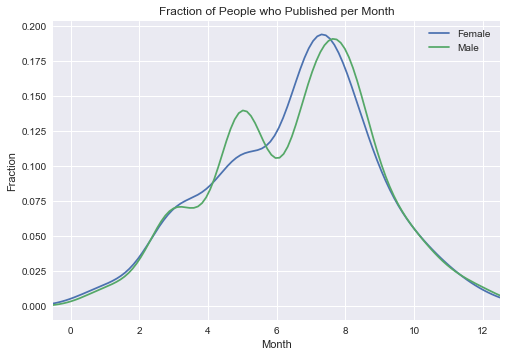

In [140]:
sns.distplot(codingdf_f["date"].dt.month, label = "Female", hist = False)
sns.distplot(codingdf_m["date"].dt.month, label = "Male", hist = False)

plt.xlabel("Month")
plt.ylabel("Fraction")
plt.title("Fraction of People who Published per Month")
plt.legend()
plt.xlim(-0.5,12.5);

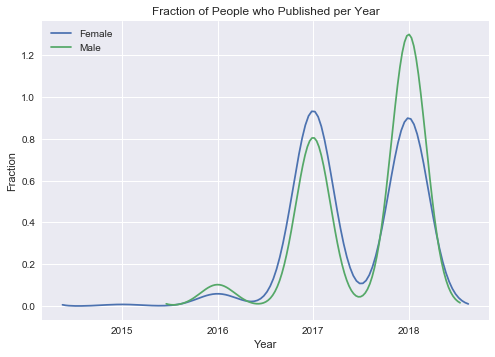

In [141]:
sns.distplot(codingdf_f["date"].dt.year, label = "Female", hist = False)
sns.distplot(codingdf_m["date"].dt.year, label = "Male", hist = False)

plt.xlabel("Year")
plt.ylabel("Fraction")
plt.title("Fraction of People who Published per Year")
plt.legend();

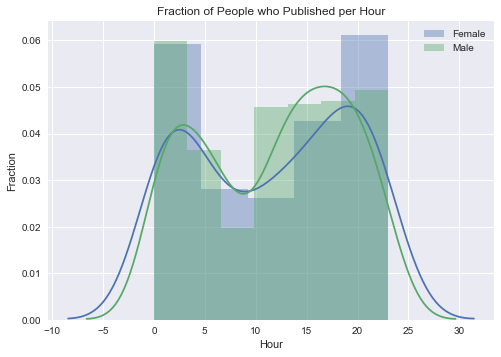

In [146]:
sns.distplot(codingdf_f["date"].dt.hour, label = "Female", hist = True)
sns.distplot(codingdf_m["date"].dt.hour, label = "Male", hist = True)

plt.xlabel("Hour")
plt.ylabel("Fraction")
plt.title("Fraction of People who Published per Hour")
plt.legend();

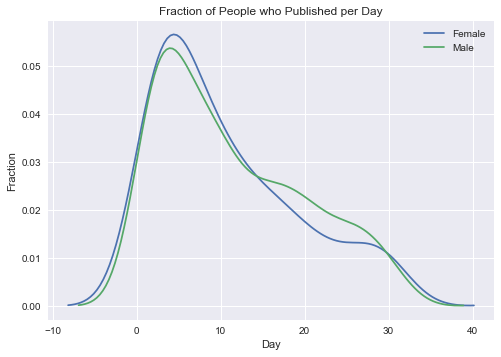

In [145]:
sns.distplot(codingdf_f["date"].dt.day, label = "Female", hist = False)
sns.distplot(codingdf_m["date"].dt.day, label = "Male", hist = False)

plt.xlabel("Day")
plt.ylabel("Fraction")
plt.title("Fraction of People who Published per Day")
plt.legend();

In [158]:
# length of article in characters 
avglencharf = codingdf_f["text"].apply(len).mean()
avglencharf

3795.214285714286

In [157]:
avglencharm = codingdf_m["text"].apply(len).mean()
avglencharm

4185.253549695741

In [159]:
# length in words
codingdf_f["text_length"] = codingdf_f["text"].str.split(' ').apply(len)
avglenwordf = codingdf_f["text_length"].mean()
avglenwordf

/Users/shalini/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


684.4464285714286

In [160]:
codingdf_m["text_length"] = codingdf_m["text"].str.split(' ').apply(len)
avglenwordm = codingdf_m["text_length"].mean()
avglenwordm

/Users/shalini/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


756.841784989858

In [161]:
avglencharf / avglenwordf

5.544939862767095

In [162]:
avglencharm / avglenwordm

5.52989228752985